<div style='text-align:center'>

# پروژه اول درس داده کاوی
## Dr. Neda Binesh
## Amazon Laptop prices report
-----------------------------

</div>

# زمینه سازی

## وارد کردن ابزار ها و کتابخانه ها

In [1]:
# importing libraries and tools

import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import itertools
import re


## راه اندازی اولیه ابزار ها
در اینجا پالت رنگی کتابخانه Seaborn را مشخص کرده و آن را ست می کنیم.

In [2]:
palette = sb.color_palette("bright",30)
palette_cmap = sb.color_palette("bright",as_cmap=True,n_colors=30)
sb.set(style="white")
sb.set_palette(palette)

print(plt.style.available)
plt.style.use("seaborn-v0_8-bright")

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


## خواندن فایل دیتا
در اینجا فایل CSV دیتا ها را بازخوانی می کنیم.

In [3]:
# reading file

df = pd.read_csv("amazon_laptop_prices_v01.csv")

# پیش پردازش (Preprocessing)


## حذف داده های ناقص (Filtering: Validation)
بعضی از فیچر ها برای رسم نمودار ها حیاتی و لازم هستند. بنابراین لازم است دیتا ها را فیلتر کرده و دیتا هایی که فیچر های لازم را ندارند یا از فرمت بقیه داده ها پیروی نمی کنند، حذف کنیم.

In [4]:
def filter_incomplete_data(row):
    # Filter out any entry that does not include all of the required columns  (Data cleanup)

    try:
        # Check for valid numeric values in each column
        return (
            pd.notna(row["price"])
            and pd.notna(row["cpu_speed"])
            and pd.notna(row["ram"])
            and pd.notna(row["screen_size"])
            and pd.notna(row["harddisk"])
            and bool(re.match(r"^\d+(\.\d+)? GHz$", str(row["cpu_speed"])))
            and bool(  # Regex check for GHz format
                re.match(r"^\d+(\.\d+)? GB$", str(row["ram"]))
            )
        )
    except Exception as e:
        return False
    
    
    
    
df = df[df.apply(filter_incomplete_data, axis=1)]


## تبدیل فیچر های عددی به فرمت عددی
در این دیتا ست بعضی از فیچر ها مثل قیمت یا اندازه صفحه با پیشوند/پسوند همراه هستند. با استفاده از Regex این وند ها را حذف می کنیم.

In [5]:
# normalize numerical data


# Extract numerical values
df["price"] = df["price"].replace("[\$,]", "", regex=True).astype(float)

# Extract CPU speed in GHz
df["cpu_speed"] = df["cpu_speed"].replace(" GHz", "", regex=True).astype(float)

# Extract RAM in GB
df["ram"] = df["ram"].replace(" GB", "", regex=True).astype(float)

# Extract screen size in inches
df["screen_size"] = df["screen_size"].replace(" Inches", "", regex=True).astype(float)

# Convert harddisk to GB (convert TB to GB)
df["harddisk"] = df["harddisk"].apply(
    lambda x: int(x.split()[0]) * 1000 if "TB" in x else int(x.split()[0])
)

# df['rating'] = df['rating'].astype(float)

## حذف داده های پرت (Filtering : Outlier Removal)
با استفاده از یک تابع بعنوان فیلتر داده های پرت را (مثل CPU با فرکانس 9000 گیگاهرتز یا 500 گیگابایت RAM) حذف میکنیم.

In [6]:
def filter_outlier_data(row):
    # Filter out any entry that does not include all of the required columns  (Data cleanup)

    return (
        row["price"] < 10_000
        and row["cpu_speed"] < 9.00  # $10k max
        and row["ram"] < 1024  # 9GHz cpu max
        and row["screen_size"] < 20  # 20 inches max
        and row["harddisk"] < 3_000  # 3TB storage max and
    )
    
    
    
    
df = df[df.apply(filter_outlier_data, axis=1)]



## آمار گیری : داده های تمیز و آماده آنالیز
حال پس از حذف داده های پرت و ناقص حدود 1000 داده کارآمد باقی می ماند که اساس کار ما این داده ها خواهد بود.

In [7]:
print(df.shape)

(1020, 14)


In [8]:
print(df.describe())

       screen_size     harddisk          ram    cpu_speed      rating   
count  1020.000000  1020.000000  1020.000000  1020.000000  618.000000  \
mean     14.728922   810.576471    14.633333     1.480637    4.573301   
std       0.928914   414.454323     7.864085     0.849692    0.503295   
min      11.600000     8.000000     2.000000     0.900000    1.000000   
25%      14.000000   512.000000     8.000000     1.100000    4.400000   
50%      14.000000  1000.000000    16.000000     1.100000    4.700000   
75%      15.600000  1000.000000    16.000000     1.200000    5.000000   
max      17.300000  2000.000000    64.000000     5.600000    5.000000   

             price  
count  1020.000000  
mean    650.563804  
std     546.032298  
min      99.990000  
25%     389.990000  
50%     459.990000  
75%     589.990000  
max    5599.000000  


In [9]:
df.head(5)

,brand,model,screen_size,color,harddisk,cpu,ram,OS,special_features,graphics,graphics_coprocessor,cpu_speed,rating,price
0,ROKC,NaN,14.0,Blue,1000,Intel Core i7,8.0,Windows 11,NaN,Integrated,Intel,1.2,NaN,589.99
12,ROKC,NaN,15.6,Blue,1152,Pentium,20.0,Windows 11,NaN,Integrated,Intel,1.1,5.0,389.99
13,HP,NaN,15.6,Black,1000,Pentium N5000,16.0,Windows 11,NaN,Integrated,Intel,1.1,4.4,459.99
17,Gateway,NaN,11.6,Blue,64,Celeron N4020,4.0,Windows 10 S,NaN,Integrated,Intel,1.1,4.0,155.00
29,ROKC,NaN,14.0,Blue,1000,Intel Core i7,8.0,Windows 11,NaN,Integrated,Intel,1.2,NaN,589.99



## Extract کردن دیتا 

در اینجا ستون های داده را از Dataframe استخراج کرده و تعدادی alias درست میکنیم تا کارمان در استفاده توابع جلوتر راحت تر باشد. 
همچنین از تابع tolist استفاده میکنیم تا دیتافریم های Pandas را به دیتا تایپ بومی لیست پایتون تبدیل کنیم تا بتوانیم عملیات های حلقوی را روی آنها انجام دهیم.


In [10]:
brands = df["brand"].tolist()
models = df["model"].tolist()
screen_sizes = df["screen_size"].tolist()
colors = df["color"].tolist()
harddisks = df["harddisk"].tolist()
cpus = df["cpu"].tolist()
rams = df["ram"].tolist()
OSs = df["OS"].tolist()
special_features = df["special_features"].tolist()
graphics = df["graphics"].tolist()
graphics_coprocessors = df["graphics_coprocessor"].tolist()
cpu_speeds = df["cpu_speed"].tolist()
ratings = df["rating"].tolist()
# price = df['price'].tolist()
# price = pd.to_numeric(df['price'], errors='coerce').tolist()
prices = df["price"].tolist()
# price = df['price'].replace('[\$,]', '', regex=True).astype(float)
# price = df['price'].str[1:].tolist()

## مشخص کردن داده های عددی

In [11]:
numerical_cols_names = ["price", "ram", "harddisk", "cpu_speed", "screen_size"]
numerical_cols_data = [prices, rams, harddisks, cpu_speeds, screen_sizes]

nominal_cols_names = ["brand","color","OS","graphics"]
nominal_cols_datas = [brands,colors,OSs,graphics]

# پردازش و رسم نمودار (Analysis)


Text(0.5, 1.0, 'Boxplot for Reviews')

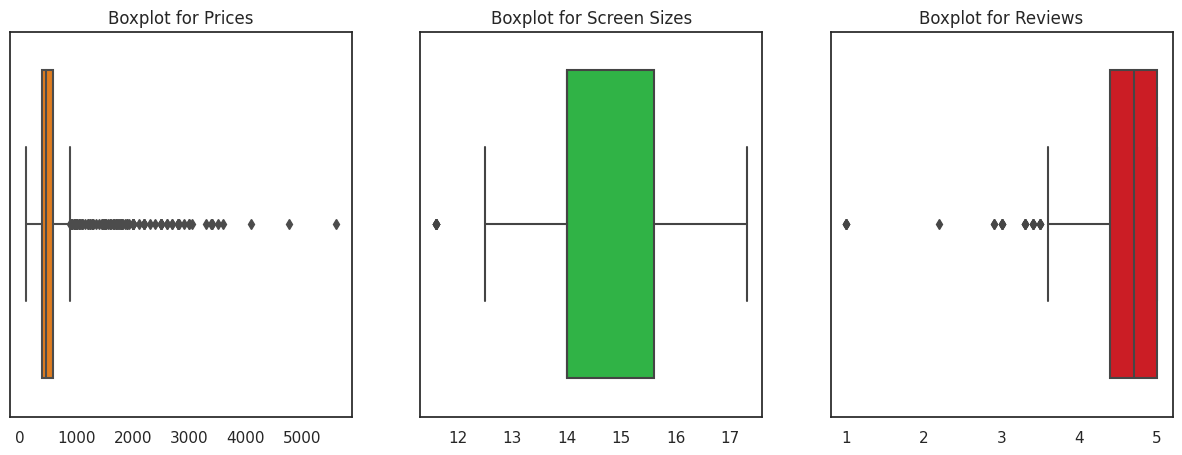

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))


sb.boxplot(x=prices, ax=axes[0], color=palette[1])
axes[0].set_title('Boxplot for Prices')


sb.boxplot(x=screen_sizes, ax=axes[1], color=palette[2])
axes[1].set_title('Boxplot for Screen Sizes')

sb.boxplot(x=ratings, ax=axes[2], color=palette[3])
axes[2].set_title('Boxplot for Reviews')



Blue         487
Black        182
Rose Gold    138
Silver         9
Gray           6
Name: count, dtype: int64


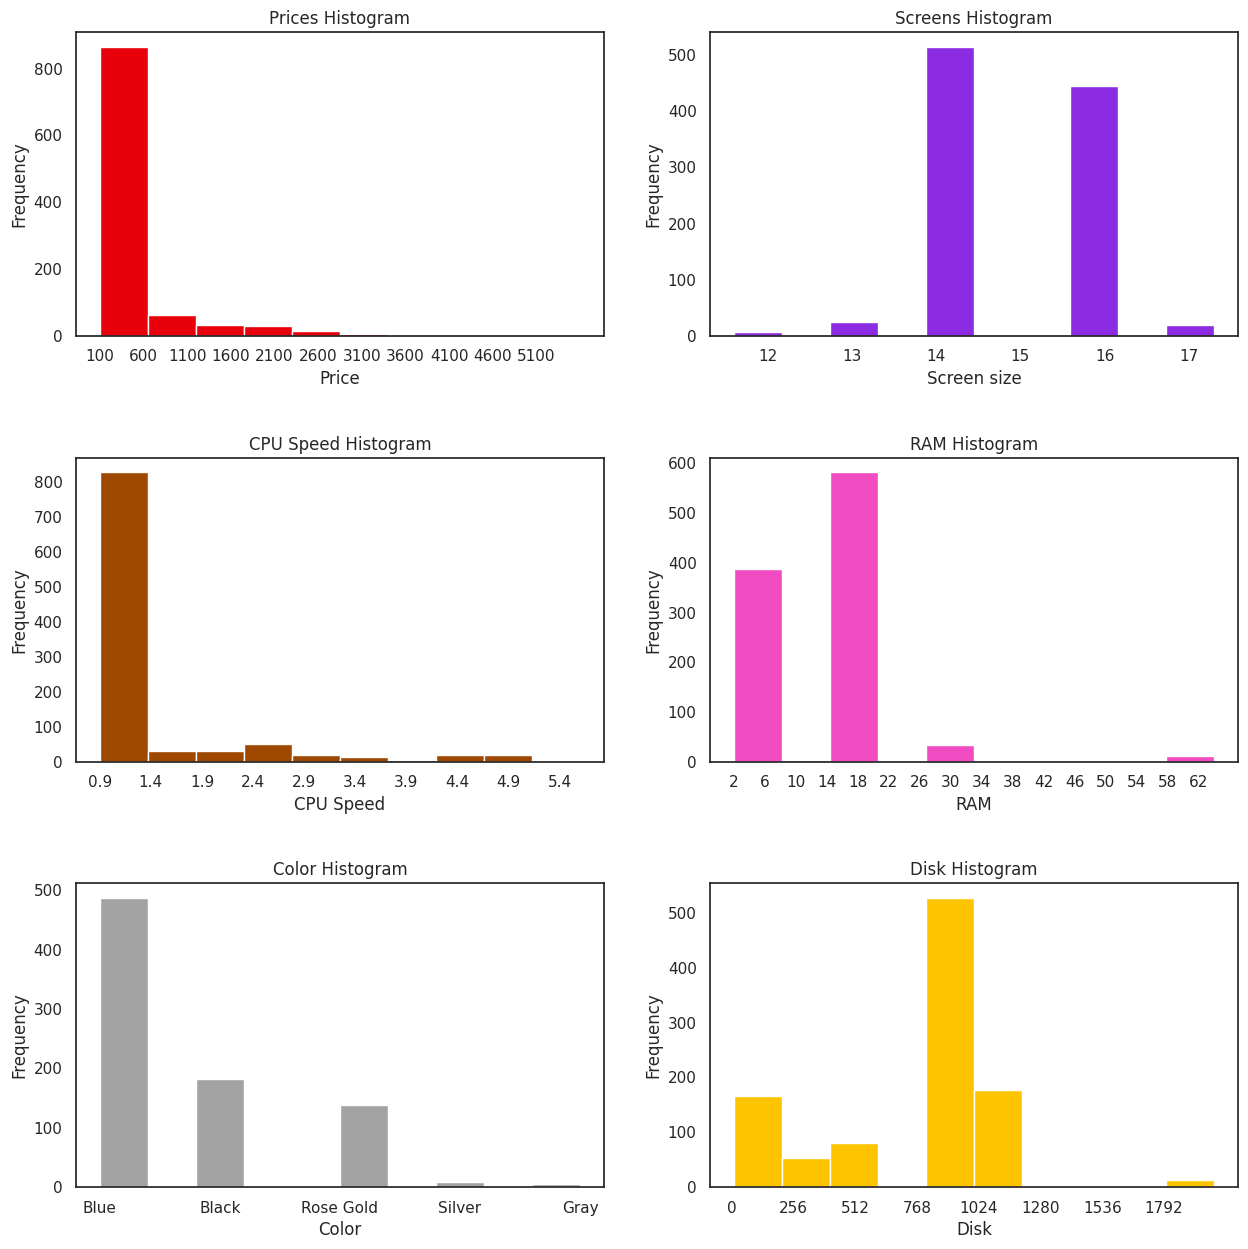

In [13]:
fig, axes = plt.subplots(3, 2, figsize=(15, 15))
# plt.tight_layout()
# Prices histogram
ax = axes[0, 0]
ax.hist(prices, bins=10, color=palette[3])
ax.set_title("Prices Histogram")
ax.set_xlabel("Price")
ax.set_ylabel("Frequency")
ax.set_xticks(np.arange(min(prices), max(prices), 500))


# Screen sizes histogram
ax = axes[0, 1]
ax.hist(screen_sizes, bins=10, color=palette[4])
ax.set_title("Screens Histogram")
ax.set_xlabel("Screen size")
ax.set_ylabel("Frequency")


# CPU Speed histogram
ax = axes[1, 0]
ax.hist(cpu_speeds, bins=10, color=palette[5])
ax.set_title("CPU Speed Histogram")
ax.set_xlabel("CPU Speed")
ax.set_ylabel("Frequency")
ax.set_xticks(np.arange(min(cpu_speeds), max(cpu_speeds), 0.5))



# RAM histogram
ax = axes[1, 1]
ax.hist(rams, bins=10, color=palette[6])
ax.set_title("RAM Histogram")
ax.set_xlabel("RAM")
ax.set_ylabel("Frequency")
ax.set_xticks(np.arange(min(rams), max(rams), 4))





# Color histogram

colors_series = pd.Series(colors)
color_counts = colors_series.value_counts()
popular_colors = colors_series[colors_series.isin(color_counts.index[color_counts > 5])]

print(popular_colors.value_counts())
ax = axes[2, 0]
ax.hist(popular_colors, bins=10, color=palette[7])
ax.set_title("Color Histogram")
ax.set_xlabel("Color")
ax.set_ylabel("Frequency")




# Disk histogram
ax = axes[2, 1]
ax.hist(harddisks, bins=10, color=palette[8])
ax.set_title("Disk Histogram")
ax.set_xlabel("Disk")
ax.set_ylabel("Frequency")
ax.set_xticks(np.arange(0, max(harddisks), 256))


plt.subplots_adjust(wspace=0.2, hspace=0.4)

# print(min(cpu_speeds), max(cpu_speeds))
# ax.set_xticks(np.arange(min(cpu_speeds), max(cpu_speeds), 10))

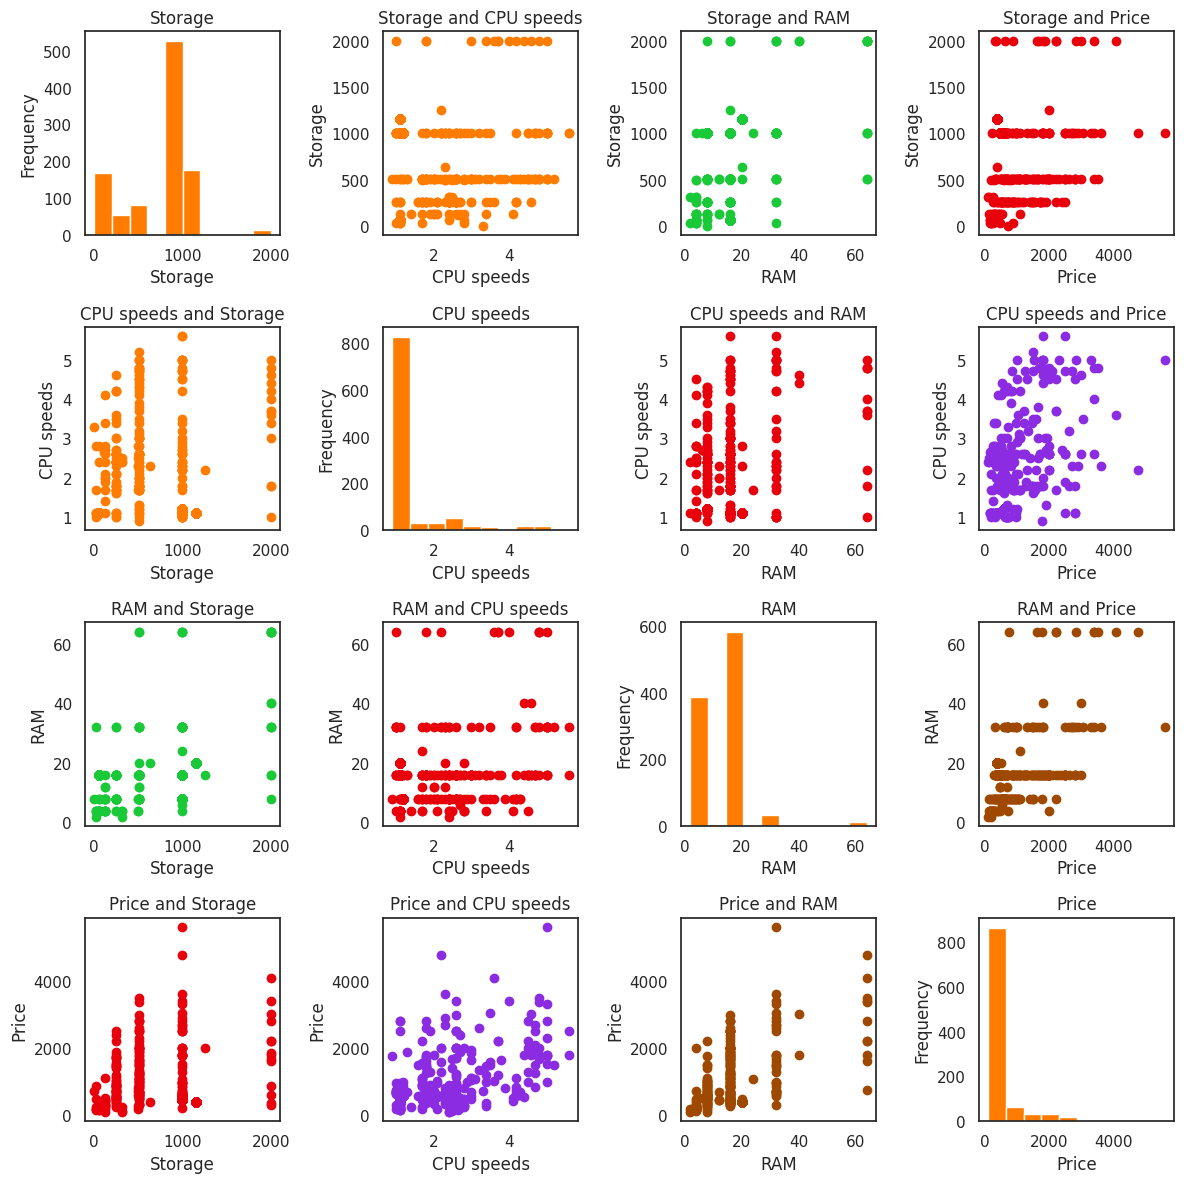

In [14]:
cols = ['Storage','CPU speeds','RAM','Price']
data = [harddisks,cpu_speeds,rams,prices]


fig, axes = plt.subplots(len(cols), len(data), figsize=(12, 12))

for i, j in itertools.product(range(len(cols)), repeat=2):
    ax = axes[i,j]
    # Scatter plot if i and j are not equal
    if i != j:
        ax.scatter(data[j], data[i], color=palette[i+j])
        ax.set_title(f'{cols[i]} and {cols[j]}')
        ax.set_xlabel(cols[j])
        ax.set_ylabel(cols[i])
   
    # Hist plot if i and j are equal
    else:
        ax.hist(data[i], bins=10, color=palette[1])
        ax.set_title(f'{cols[i]}')
        ax.set_xlabel(cols[i])
        ax.set_ylabel('Frequency')

plt.tight_layout()


Text(0.5, 1.02, 'Scatter Plot Matrix')

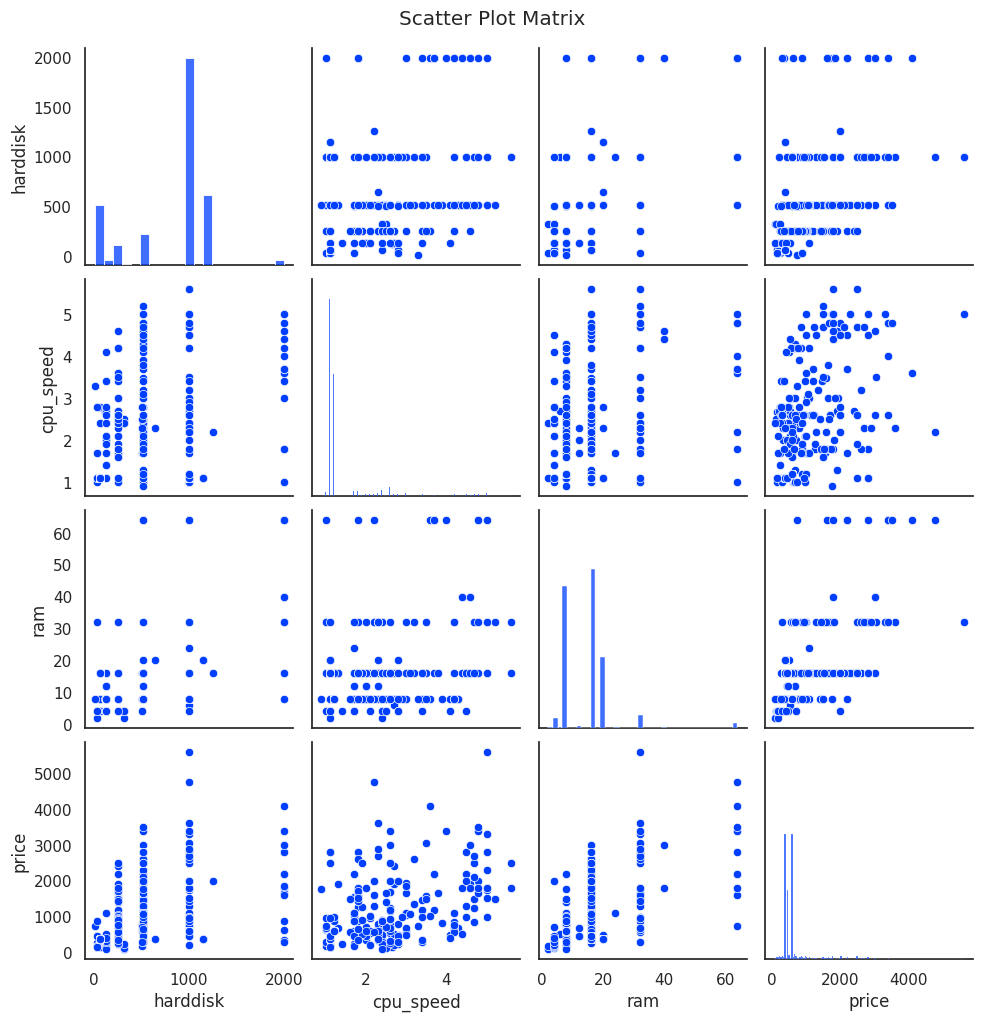

In [15]:
cols = ['harddisk','cpu_speed','ram','price']

sb.pairplot(df[cols])
plt.suptitle('Scatter Plot Matrix', y=1.02)


Text(0.5, 1.0, 'Storage and Prices 2D Histogram')

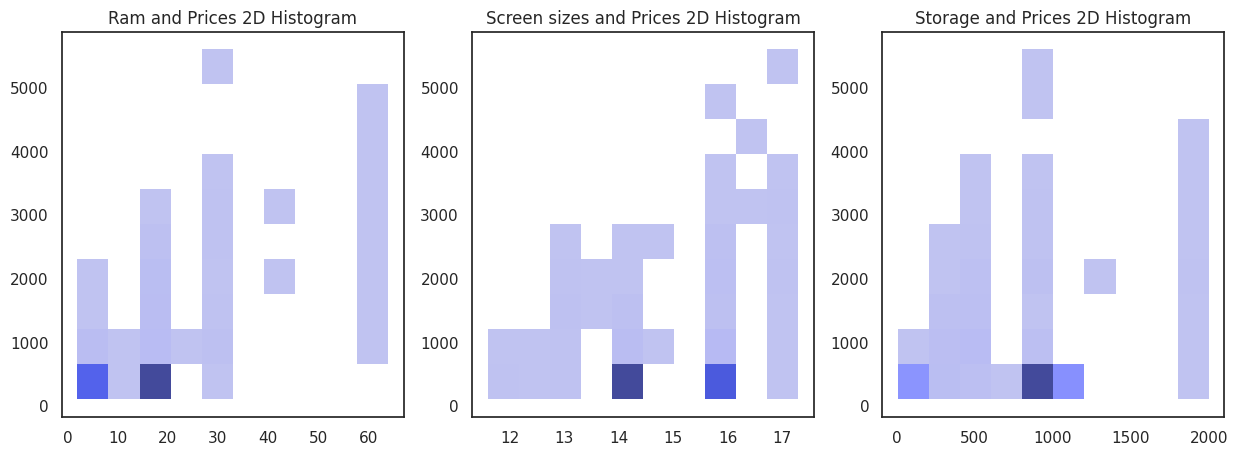

In [16]:

# Create a 2D Histplot
fig, axes = plt.subplots(1,3, figsize=(15, 5))


ax = axes[0]
sb.histplot(x=rams,y=prices, ax=ax, bins=10)
ax.set_title("Ram and Prices 2D Histogram")



ax = axes[1]
sb.histplot(x=screen_sizes,y=prices, ax=ax, bins=10)
ax.set_title("Screen sizes and Prices 2D Histogram")



ax = axes[2]
sb.histplot(x=harddisks,y=prices, ax=ax, bins=10)
ax.set_title("Storage and Prices 2D Histogram")


In [17]:
def filter_brands_by_sales(dataframe, threshold=50):
    brand_counts = dataframe['brand'].value_counts()
    popular_brands = brand_counts[brand_counts > threshold].index
    filtered_df = dataframe[dataframe['brand'].isin(popular_brands)]
    return filtered_df

Text(0, 0.5, 'Price')

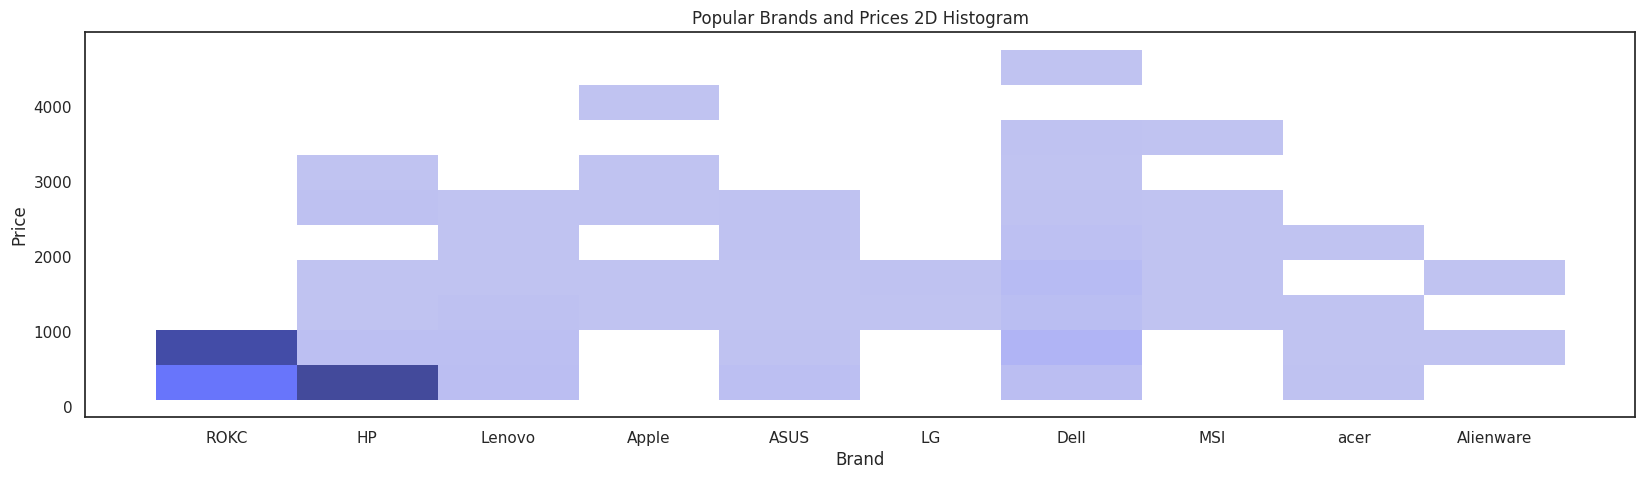

In [18]:
fig, axes = plt.subplots(1,1, figsize=(20, 5))

popular_brands_df = filter_brands_by_sales(df, threshold=2)

ax = axes
sb.histplot(x=popular_brands_df['brand'],y=popular_brands_df['price'], ax=ax, bins=10)
plt.title("Popular Brands and Prices 2D Histogram")
plt.xlabel("Brand")
plt.ylabel("Price")

<Axes: >

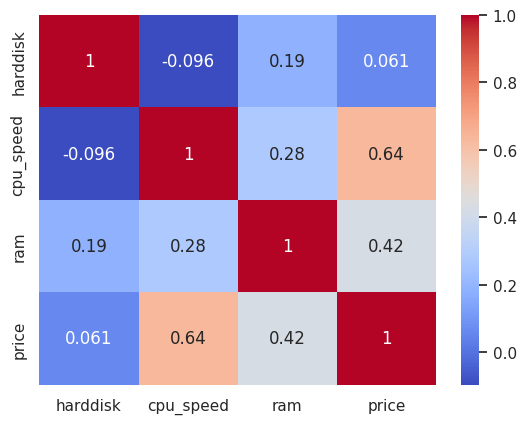

In [19]:
cols = ['harddisk','cpu_speed','ram','price']

corr_matrix = df[cols].corr()

# Create a heatmap
sb.heatmap(corr_matrix, annot=True, cmap="coolwarm")

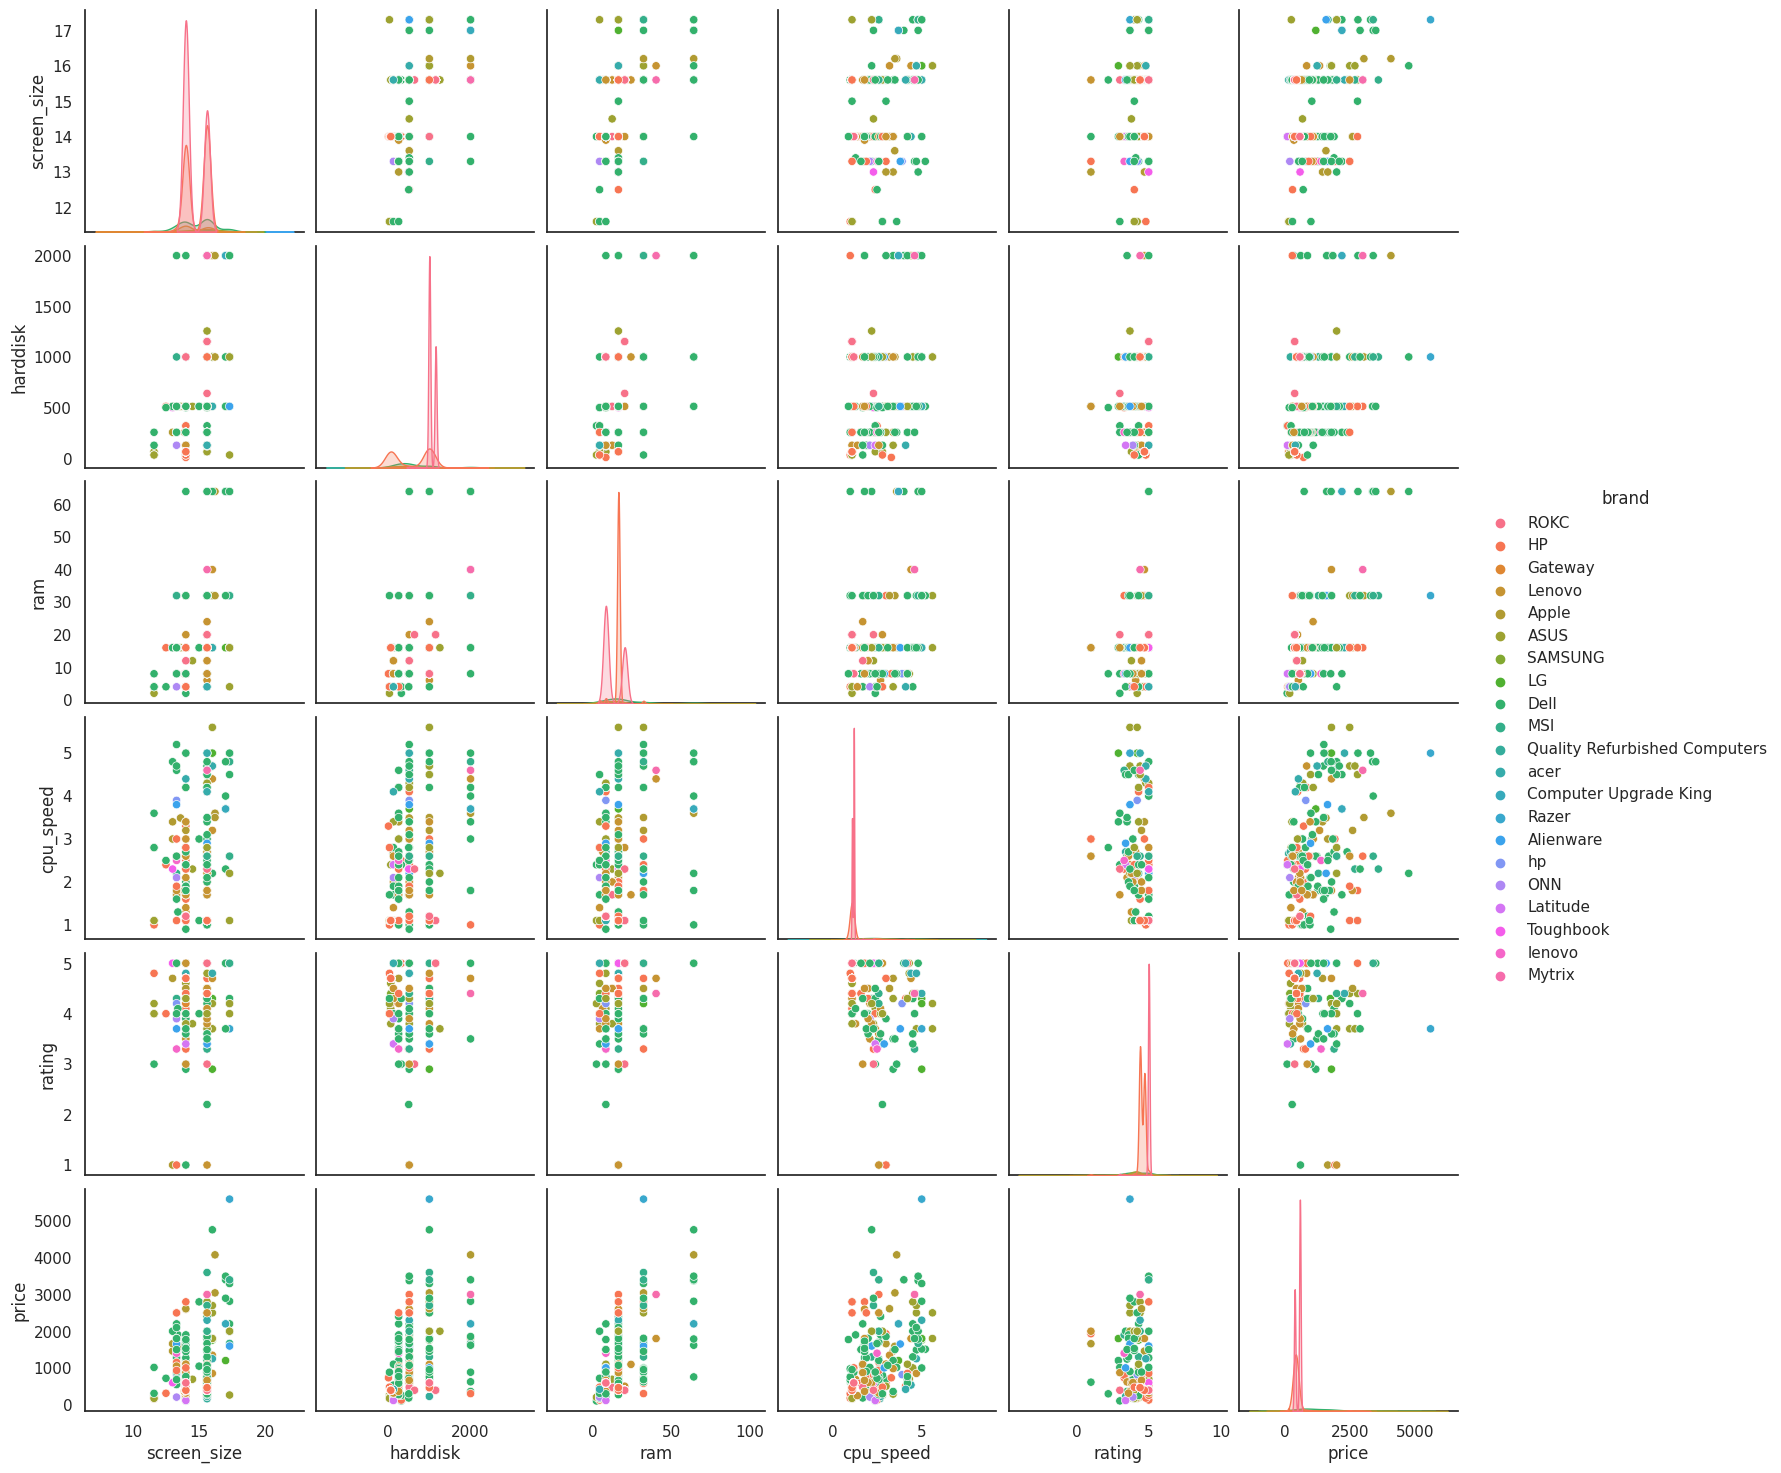

In [20]:
sb.pairplot(df, hue="brand")